In [168]:
# 라이브러리 로드

import requests
from bs4 import BeautifulSoup as bs
import urllib
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
import matplotlib as mpl
print('matplotlib ' + mpl.__version__)

matplotlib 3.2.2


In [3]:
# 맷플롯립 한글 폰트 지정
import platform
from matplotlib import font_manager, rc

# 한글 설정시 마이너스 부호 깨지는 것 방지
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    # mac
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    # windows
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

# 1. 크롤러 구축 (각 사이트에 맞는 크롤러 구축 후 통합)

In [4]:
# 에어비앤비,호텔스닷컴,여기어때,부킹닷컴 크롤링 코드 

class Hotel:
    def __init__ (self,place,checkin,checkout,pages):
        self.place=place
        self.checkin=checkin
        self.checkout=checkout
        self.pages=pages
        
#airbnb 크롤링
    def airbnb(self):  #place = 장소, checkin = 체크인 날짜, checkout :체크아웃 날짜, pages=검색하고자 하는 페이지 수
    
    
        result_list=[]  #크롤링 최종 결과를 담을 리스트

        #에어비앤비는 offset이 20단위로 페이지가 변화 ex)offset 0 : 1페이지 , offset 1~20: 2페이지 
        for page in range(1,self.pages+1): #입력받은 페이지 수만큼 모두 크롤링 하기 위해
            if page==1:  #page가 1이면 offset=0
                offset=0
            else:
                offset=page*20  #1보다 크면 page*20


            #리퀘스트할 url과 파라미터 설정
            base_url="https://www.airbnb.co.kr/s/%s/homes" %self.place
            params={'query': [self.place],
             'federated_search_session_id': ['e296e38b-6ec1-4296-9a81-f762cfb2c92a'],
             'source': ['structured_search_input_header'],
             'search_type': ['pagination'],
             'tab_id': ['home_tab'],
             'checkin': [self.checkin],
             'refinement_paths[]': ['/homes'],
             'checkout': [self.checkout],
             'section_offset': ['2'],
             'items_offset': [offset]}

            resp=requests.get(base_url,params=params)
            soup=bs(resp.text)
            item_tags=soup.select("#FMP-target > div > div > div > div")
            len(item_tags[0])


            #해당 숙소에 대한 상세페이지 url을 가져옴
            a_tags=item_tags[0].find_all("a")
            url_list=[]
            for i in a_tags:
                url_list.append("https://www.airbnb.co.kr%s" %i.get("href"))


            #숙소들의 가격정보를 가져옴
            price_tags=item_tags[0].find_all("span", class_="_1p7iugi")
            price_list=[]
            for i in price_tags:
                try:
                    price=i.text.split(":")[2]
                except:
                    price=i.text.split(":")[1]
                price=price.replace("₩","")
                price=price.replace(",","")
                price_list.append(float(price))
    
            #숙소들의 리뷰 개수를 가져옴
            count_reviews=item_tags[0].find_all("span",class_="_krjbj")
            count_reviews
            count_reviews_list=[]
            for i in count_reviews:
                if "후기" in str(i):
                    count_reviews_list.append(i.text.split(" ")[1].replace("개",""))

            #숙소들의 이름과 평점을 가져옴
            name_tags=item_tags[0].find_all("div",class_="_bzh5lkq")
            rate_tags=item_tags[0].find_all("span",class_="_10fy1f8")

            result=[]

            #앞에서 추출한 정보들을 딕셔너리화 하여 result 리스트에 추가
            for n,r,p,c in zip(name_tags,rate_tags,price_list,count_reviews_list):
                result.append({
                    "이름":n.text,
                    "평점":float(r.text),
                    "리뷰 개수" :int(c),
                    "가격":int(p),
                    "사이트":"AirBnb"
                })
            for item in result:
                if item["이름"] not in result_list:
                    result_list.append(item)



        #최저 가격 숙소 / 최고 평점 숙소 구하기            
        min_price=1000000
        name_of_min_price=""
        min_url=""

        highest_rate=0.00
        name_of_hr=""
        highest_url=""

        for item in result_list:
            price=item["가격"]
#             price=price.replace("₩","")
#             price=float(price.replace(",",""))

            if price<min_price:
                min_price=price
                name_of_min_price=item["이름"]
#                 min_url=item["링크"]

            rate=float(item["평점"])
            if rate>highest_rate:
                highest_rate=rate
                name_of_hr=item["이름"]
#                 highest_url=item["링크"]


        return result_list,"최저 가격 숙소 : %s (가격 : %d), (url : %s )" %(name_of_min_price,min_price,min_url),"최고 평점 숙소 : %s (평점 : %.2f), (url : %s)" %(name_of_hr,highest_rate,highest_url)

# #호텔스닷컴
    
#     def hotels(self):

#         result_list=[]
#         for page in range(1,self.pages+1):

#             base_url='https://kr.hotels.com/search/listings.json'
#             params={
#                 #'pg-offset':page,
#                 #'distination-id':'1644457', 
#                 'q-check-in':self.checkin,
#                 'q-destination':self.place,
#                 'q-check-out':self.checkout,
#                 'q-rooms':1,
#                 'q-room-0-adults':1,
#                 'q-room-0-children':0,
#                 'pg':1,
#                 #'start-index':1,
#                 'pn':page,
#                 #'resolved-location':'REGION:1644457:UNKNOWN:UNKNOWN'
#             }

#             headers={
#                 'content-type': 'application/javascript',
#                 'x-requested-with': 'XMLHttpRequest',
#                 #'referer':'https://kr.hotels.com/search.do?resolved-location=REGION%3A1644457%3AUNKNOWN%3AUNKNOWN&destination-id=1644457&q-destination={0}&q-check-in=2020-08-16&q-check-out=2020-08-17&q-rooms=1&q-room-0-adults=1&q-room-0-children=0'.format(urllib.parse.quote('제주도')),
#                 'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.105 Safari/537.36',
#                 'cookie': "asc=1; homepage_search_data=7KCc7KO864-ELCDsoJzso7zsi5wsIO2VnOq1rQ..%2F%2F2020%2F08%2F16%2F%2F2020%2F08%2F17%2F%2F1%2F%2Fyyyy%2FMM%2Fdd%2F%2F1644457%2F%2F; guid=8c8ca612-b270-42cb-95aa-6232c2538458; user=QSprb19LUnxIQ09NX0tS; dr=AAA~1596523818~5C85BBDD535AE5EBF43E87FBF3ED905266EB65950AFBFD78AC0671363A77CA79; akacd_pr_20=1601707820~rv=31~id=44ca8f82368ff8df2ac1cef34c3ccc77; bm_sz=91F45291ECCBD9CF669AE98B49CA6C7D~YAAQa3pGaFBIOoBzAQAALzY8uAjOZf4bEil+pJ9j7T4xHGo5L0We9RrvFkah4Ntqo/cwcLTTJE/iBUXVgkfqE0iJKW9BFb7MP7TecuUec4RqjpNsP2kaEjHxE5mKNYefWc2HoK06cqN5xm/nP7KJBfW4ANgO3yTiCM6bebnDHYkGER21/OCeV4M8NejdwiHs; _ga=GA1.2.20859871.1596523819; _gid=GA1.2.1549673115.1596523819; s_ecid=MCMID%7C78976063976117546201547030336521815933; AMCVS_C00802BE5330A8350A490D4C%40AdobeOrg=1; mvthistory=eJxNj0kKQjEQRG8U0lN62LoRRAQv4PrfwcPb%2Bd2Kq7w8qorEbawxx0EQQJaEgap5zmCXsemwgAl8ugQZuKUHQAZOyUjDva3MqidYRWmzt4RZoGoFhr1iCpXXAOd1Spzm3xEko2IIFMQBFUZZNY5i0uBdX8QVg7xo2XFg0O%2BTANIgXOucvKilzupTMHJXeGGBQA%2FCZv1jK6bN3mHqF%2Be%2B27n%2Fvl4e99ft%2BQErFlFN; AMCV_C00802BE5330A8350A490D4C%40AdobeOrg=-1330315163%7CMCIDTS%7C18479%7CMCMID%7C78976063976117546201547030336521815933%7CMCAID%7CNONE%7CMCOPTOUT-1596531019s%7CNONE%7CMCAAMLH-1597128619%7C11%7CMCAAMB-1597128619%7Cj8Odv6LonN4r3an7LhD3WZrU1bUpAkFkkiY1ncBR96t2PTI; s_cc=true; _abck=2ED1A02051B8DEB245303D2079BFA297~0~YAAQa3pGaG1IOoBzAQAAYTo8uATWuv2nvnfdxtDM1HX8spMwJ/uePIa0J+yDDpECBjueRhJJnTCQeLN65aS9O2/FNU6d0/WCMG5BlCwygcTvGmmf7DWIa9LrwFv3vUW4KMvUIUG512ERyfZN6zGK1qfws1T/EYZq4oqOB5Z3c7VJPbnqwsjjsUB4/i1LiWyT4L8KcN0G7XXYdNhUl1lHg5uVd0k0Rlwxwk5ErlZ0/sI93o/ZSyhcdjCE/+mhsnRk0JPWMuhjnPmCvo7Z0ASd18VykJL4SQ3HDqBpsWs0pfZLvx7V0gFpd0DFflGEWV8jrY/lmk4QRw==~-1~-1~-1; _gcl_au=1.1.160751177.1596523820; _fbp=fb.1.1596523820167.896421725; 0e16e784-167b-49ee-b1ac-0ff7866eb4fbfaktorId=5cac8980-8e5b-4cc8-82d6-c10efc3d3428; lastConsentChange=1596523820269; 0e16e784-167b-49ee-b1ac-0ff7866eb4fbeuconsent=BO3mjO6O3mjO6ADABAENDV-AAAAx6ATgAUABoAEAAKwAXABkAEAAMgAaQBEAEUAI4ATAAngBbAEEAJAATgBCACpAHVARqA; 0e16e784-167b-49ee-b1ac-0ff7866eb4fbcconsent=BO3mjO6O3mjO6ADABAENA7AAAAAOWAAA; 0e16e784-167b-49ee-b1ac-0ff7866eb4fbfaktorChecksum=-1176279445; __gads=ID=0b734ce775df8ba2-222c1fd2c6c2005b:T=1596523822:S=ALNI_MZhdUG_e5KVdQLyxGd-QTgPh34YZg; xdid=0e1a2a2a-35f6-4831-a4f6-f3389ef1ca7a|1596523822|kr.hotels.com; xdidp=0e1a2a2a-35f6-4831-a4f6-f3389ef1ca7a|1596523822|kr.hotels.com; s_sq=%5B%5BB%5D%5D; visitId=edbcaa2e-4968-4009-ac85-383907b77d5f; SESSID=kmF9C5mRd1F3cSUDGpr_gCaDoZ.sa-6f74c7cf76-x4jn8; Session_Pageviews=6; _uetsid=c6e7370525e12b88d62d48ad3703a7c3; _uetvid=3363ca2720f5a4cef91d6a35a5ae68ab",
#                 #'pragma': 'no-cache',
#                 #'cache-control': 'no-cache',
#                 #'accept': 'application/json, text/javascript, */*; q=0.01',
#                 #'accept-language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
#                 #'accept-encoding': 'gzip, deflate, br'

#             #     'cookie': 'channel=DC; 30dlt=seo.hcom.kr.b2.search.naver.com; guid=70b194a6-7d06-4407-813d-439ddc81e8b1; user=QSprb19LUnxIQ09NX0tS; akacd_pr_20=1601370854~rv=10~id=56b99db0bffa807a7ae68b57c1f84d62; _ga=GA1.2.262126391.1596186854; s_ecid=MCMID%7C18020916849438730392200037473831731739; _fbp=fb.1.1596186855014.1096204561; _gcl_au=1.1.2093965117.1596186855; __gads=ID=28a1f36c47d1b899:T=1596186855:S=ALNI_MbMfgFuOVpeHde-Lxvoqy6try5X3w; xdid=03a4919c-5c4e-476b-9704-1db0fd86a8cf|1596186857|kr.hotels.com; xdidp=23fa12ed-bf86-42d0-b153-3665d6e271eb|1596186754|expedia.co.kr; lastConsentChange=1596186857180; mvthistory=eJxNj0luRCEMRG%2BEKA942PampSiKlAtk%2Fe%2BQwwe%2B3a2seDyVyxA%2B1pjjYiTYN1GS2T5nSug4dHliQm63QQcdGQnswC2FeES01VnjG7yifDhaYhaYeYFTt7ih8pYIWbek6fEqIXYuRpISDVSYdFU5qWtD9PhiqRj2xcqOi5LfnwS0QaXaZfPiljZrnlNIeoQnqsdSZFFJRZfjsP1jL%2BbD0WHu1%2B9d4feu3%2Bfj6%2FPn4%2FsPA1NT2Q%3D%3D; bm_sz=9BD21E821845D51FA0D9B135BB256B3A~YAAQDXpGaMvdmYZzAQAA7BL3sgjXMidVKi2JZezEhByPD+UlXFPyGWEuydcxo7jaG5deLqOuRULrEn/lhgOo6iEtj0Wad9xJ0uolA4BJwtwL18+2xpptdBd8jS3LfCLmEC2uX/WB2NnK4m4x4mzrUm7mHQGUykHOubX9A0cqY4zyEdtY0AH0PZ63K2zYl6Mi; asc=1; dr=AAA~1596435404~4AF6F0445D3489A1E092F641066F96B93D40B40DDD943022EE1E98D4913A7C2F; _gid=GA1.2.1546820872.1596435403; AMCVS_C00802BE5330A8350A490D4C%40AdobeOrg=1; s_cc=true; _abck=0D541D156BC09BE7D94D3AADD67548B2~0~YAAQPpc7F7sM/YBzAQAA3mYGswS9B4zk5w3WOr8TTX6EdGFztlMwMx528/eu2Vz3EQaN3+8S3onODcjC4mo7KcYCpqKKLtj1ypt21eC/Yywv7637PKmn2lQ4e+wTFI7Sy3+QG9Y26Wqe65goPJIbp8xKgM9x1qhhWo0ZCFQnY6q5ei/AfEMj5eWcm5pUUd8yCmTmwU2Ed0icdnCyKmuepD4P5rE9Qog//nbnhsKAhm5Kdsy8YVfYcjxBPhm72gfx92QF61+SXsk7W2VFnJkZ3fUsxWSqVziuxqLi8F4uVoW7iZ6FlEin0WTebWhrTlHO9xBgc7tcAw==~-1~-1~-1; homepage_search_data=7KCc7KO864-ELCDsoJzso7zsi5wsIO2VnOq1rQ..%2F%2F2020%2F08%2F16%2F%2F2020%2F08%2F17%2F%2F1%2F%2Fyyyy%2FMM%2Fdd%2F%2F1644457%2F%2F; visitId=9c2e2fae-5554-4ea6-a40b-89f3d70f6305; SESSID=d1zQ1OkaL9VJyQvfYjWcg2o8sR.sa-665cf686c4-7q8g6; s_sq=%5B%5BB%5D%5D; aws=1; _gat=1; AMCV_C00802BE5330A8350A490D4C%40AdobeOrg=-1330315163%7CMCIDTS%7C18478%7CMCMID%7C18020916849438730392200037473831731739%7CMCAAMLH-1596791653%7C11%7CMCAAMB-1597047604%7CRKhpRz8krg2tLO6pguXWp5olkAcUniQYPHaMWWgdJ3xzPWQmdj0y%7CMCOPTOUT-1596450004s%7CNONE%7CMCAID%7CNONE; Session_Pageviews=14; _uetsid=f42780afb3dcaf6da3acf7261a71a6e4; _uetvid=26e44a5e73df2819b24f5fccdadd9add'
#             }

#             s = requests.Session()
#             resp=s.get(base_url,params=params,headers=headers)
#             items=json.loads(resp.text)


#             results=items['data']['body']['searchResults']['results']


#             hotels_list=[]

#             for i in range(len(results)):
#                 hotels_names=items['data']['body']['searchResults']['results'][i]['name']
#                 if ('guestReviews' in items['data']['body']['searchResults']['results'][i])==False:
#                     hotels_stars=0
#                 else:
#                     hotels_stars=items['data']['body']['searchResults']['results'][i]['guestReviews']['rating']
#                     hotels_reviews=items['data']['body']['searchResults']['results'][i]['guestReviews']['total']
#                 if ('soldOut' in items['data']['body']['searchResults']['results'][i])==False:
#                     hotels_prices=items['data']['body']['searchResults']['results'][i]['ratePlan']['price']['exactCurrent']
#                 else:
#                     hotels_prices='SoldOut'

#                 hotels_list.append({
#                     '이름': hotels_names,
#                     '평점': float(hotels_stars)/2,
#                     '리뷰 개수': int(hotels_reviews),
#                     '가격': int(hotels_prices),
#                     "사이트":"호텔스닷컴"})
                    
#             for hotel in hotels_list:
#                 if hotel not in result_list:
#                     result_list.append(hotel)

#         return result_list


#여기 어때

    def yeogi(self):
      base_url = "https://www.goodchoice.kr/product/result"
      params={"keyword" : [self.place],
      "sel_date":[self.checkin],
      "sel_date":[self.checkout]}

      resp=requests.get(base_url,params=params)
      soup=bs(resp.text)
      item_tags=soup.select("#poduct_list_area")
      map_html=item_tags[0].find_all("div",class_="map_html")


      #가격 리스트
      price_list=[]

      for tag in map_html:
        price_tags=tag.find_all("b")

        # try:
        #   print(price_tags[1].text)
        # except:
        #   print(price_tags[0].text)

        try:
          price=price_tags[1].text
          price=price.replace(",","")
          price=int(price.replace("원",""))
          price_list.append(price)
        except:
          price=price_tags[0].text
          price=price.replace(",","")
          price=int(price.replace("원",""))
          price_list.append(price)

      #평점 리스트
      num_of_rates=item_tags[0].find_all("p",class_="score")

      rate_list=[]

      for tag in  num_of_rates:
        rate_list.append(float(tag.find("em").text)/2)


      #리뷰 개수 리스트
      num_of_reviews=item_tags[0].find_all("p",class_="score")

      count_list=[]  #리뷰 개수

      for tag in  num_of_reviews:
        num_of_review=list(tag)[2]
        num_of_review=num_of_review.replace("(","")
        num_of_review=int(num_of_review.replace(")",""))

        count_list.append(num_of_review)


      #숙박 시설 이름 리스트

      names=item_tags[0].find_all("strong")

      name_list=[]

      for name in names:
        name_list.append(name.text[5:].strip())


      #크롤링한 정보들 모으기
      result=[]
      for n,r,c,p in zip(name_list,rate_list,count_list,price_list):
        result.append({
        "이름":n,
        "평점":r,
        "리뷰 개수" :c,
        "가격":p,
        "사이트":"여기어때"})

      return result


    
# #야놀자

#     def yanolja(self):
#         result_list=[]
#         for page in range(1,self.pages+1):
#             base_url = "https://www.yanolja.com/api/v1/contents/search"
#             params = {
#                 'capacityAdult':1,
#                 'capacityChild':0,
#                 'page':page,
#                 'limit':20,
#                 'keyword':self.place,
#                 'checkinDate':self.checkin,
#                 'checkoutDate':self.checkout,
#                 'searchKeyword':self.place,
#                 'advert': 'KEYWORD',
#                 'searchType': 'all',
#                 'all': 1,
#                 'sort': 100,
#                 'themes': None,
#                 'lat': '37.50681',
#                 'lng': '127.06624',
#                 'capacityChildAges': None  
#             }

#             headers = {
#                 'Referer' : 'https://www.yanolja.com/search/{0}?placeListType=search&keyword={0}'.format(urllib.parse.quote(self.place)),
#                 'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.105 Safari/537.36',
#                 'X-Requested-With': 'XMLHttpRequest',
#                 'Accept': 'application/json, text/plain, */*',
#                 'Accept-Encoding': 'gzip, deflate, br',
#                 'Accept-Language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
#             #     'Cookie': 'ACEUCI=1; %2Fsearch%2F%EC%A0%9C%EC%A3%BC%EB%8F%84%2Fkeyword-all={%22keyword%22:%22%EC%A0%9C%EC%A3%BC%EB%8F%84%22%2C%22searchKeyword%22:%22%EC%A0%9C%EC%A3%BC%EB%8F%84%22%2C%22checkinDate%22:%222020-08-16%22%2C%22checkoutDate%22:%222020-08-17%22%2C%22capacityAdult%22:1%2C%22capacityChild%22:0%2C%22capacityChildAges%22:%22%22}; cgntId=ap-northeast-2%3A2b47caae-3694-44f0-9d2b-43c98b30c098; yanolja_sid=s%3A0K-pijLPMujuW6NI5cJVcGOYBO2FXY0h.ZwiC623ThkJsrpFM9m7MiLj%2F8qYFHr3272Xla0K8NCk; SavedFiltersKey=/search/%EC%A0%9C%EC%A3%BC%EB%8F%84/keyword-all; ACEUACS=1596521299174217533; ACEFCID=UID-5F28FB542D0B4D05779333B5; _fbp=fb.1.1596521300441.1991528559; _ga=GA1.2.1408952294.1596521300; _gid=GA1.2.788840749.1596521300; location={%22latitude%22:%2237.50681%22%2C%22longitude%22:%22127.06624%22%2C%22address%22:%22%EC%84%9C%EC%9A%B8%ED%8A%B9%EB%B3%84%EC%8B%9C%20%EA%B0%95%EB%82%A8%EA%B5%AC%20%ED%85%8C%ED%97%A4%EB%9E%80%EB%A1%9C108%EA%B8%B8%2042%22%2C%22addressShort%22:%22%EC%84%9C%EC%9A%B8%ED%8A%B9%EB%B3%84%EC%8B%9C%20%EA%B0%95%EB%82%A8%EA%B5%AC%20%ED%85%8C%ED%97%A4%EB%9E%80%EB%A1%9C108%EA%B8%B8%22%2C%22addressOnlyRoad%22:%22%ED%85%8C%ED%97%A4%EB%9E%80%EB%A1%9C108%EA%B8%B8%22}; wcs_bt=ae93a192ec48a4:1596521393; AWSALB=zm/Jfq0CVy83/Q/bcMcY2ADivgyVdh6KNQc6bG1tPs9SA7T5733p2wvOClRpxNMSodWkruizJEGIcJbThOG1sBYm+WURo+8cqojOGppWN4ykkwQMNbQuiwexg5Nx; AWSALBCORS=zm/Jfq0CVy83/Q/bcMcY2ADivgyVdh6KNQc6bG1tPs9SA7T5733p2wvOClRpxNMSodWkruizJEGIcJbThOG1sBYm+WURo+8cqojOGppWN4ykkwQMNbQuiwexg5Nx'
#             }

#             ## 호텔리스트가 홈페이지랑 다르게 나옴 -> 쿠키가 계속 갱신되는 것을 방지하기 위해 -> 처음 홈페이지에 들어가자마자의 쿠키를 저장해놓는다.
#             s = requests.Session()
#             s.get("https://www.yanolja.com/search/{0}?placeListType=search&keyword={0}".format(self.place))
#             resp = s.get(base_url, params=params, headers=headers)
#             # resp = requests.get(base_url, params = params, headers=headers)


#             item_li = json.loads(resp.text)

#             item_list = []
#             #name_list = []
#             #score_list = []
#             #price_list = []


#             for i in range(20):
                
                

#                 # 호텔 이름

#                 name = item_li['motels']['lists'][i]['name']
#                 #name_list.append(name)
#             #print(name_list)



#                 # 호텔 점수

#                 score = item_li['motels']['lists'][i]['reviewScore']
#                 #score_list.append(score)
#             #print(score_list)



#                 # 리뷰 개수

#                 count = item_li['motels']['lists'][i]['reviewCounts']
#                 #count_list.append(count)
#             #print(count_list)



#                 # 호텔 가격 = > 예약마감이면 예약마감이 뜬다.

#                 if len(item_li['motels']['lists'][i]['displayPrices']) == 1:
#                     if item_li['motels']['lists'][i]['displayPrices'][0]['priceNote'] == '예약마감':
#                         continue
#                         #price_list.append(price)

#                     else:
#                         price = item_li['motels']['lists'][i]['displayPrices'][0]['rawDiscountPrice']
#                         #price_list.append(price)

#                 elif len(item_li['motels']['lists'][i]['displayPrices']) >= 2:
#                     for j in range(2):
#                         if item_li['motels']['lists'][i]['displayPrices'][j]['badgeText'] == '숙박특가':
#                             if item_li['motels']['lists'][i]['displayPrices'][j]['priceNote'] == '예약마감':
#                                 continue
#                                 #price_list.append(price)

#                             else:
#                                 price = item_li['motels']['lists'][i]['displayPrices'][j]['rawDiscountPrice']
#                                 #price_list.append(price)
#             #print(price_list)



#                 item_list.append({'이름' : name, 
#                                   '평점' : float(score),
#                                   '리뷰 개수' : int(count),
#                                 '가격': price,
#                                 "사이트":"야놀자"})
                
                
#             result_list.extend(item_list)    
#         return result_list    

    
    
#4 부킹닷컴

    def booking(self):
        base_url='https://www.booking.com/searchresults.ko.html'
        total=[]
        for i in range(self.pages):
            params={
            'top_ufis':1,
            'rows':25,
            'group_adults':1,
            'group_children':0,
            'label_click':'undef',
            'checkin_month':self.checkin.split("-")[1],
            'checkin_monthday':self.checkin.split("-")[2],
            'checkin_year':self.checkin.split("-")[0],
            'checkout_month':self.checkout.split("-")[1],
            'checkout_monthday':self.checkout.split("-")[2],
            'checkout_year':self.checkout.split("-")[0],
            'no_rooms':1,
            #'raw_dest_type':'region',
            'offset':25*i,   
            'sb_price_type': 'total',
            'ss': self.place,
            #'src_elem': 'sb', 
            #'ss_all':0,
            #'ssb': 'empty',
            #'dest_type': 'region',
            #'search_pageview_id': 'b78a37b8196a0080'
            'search_selected':1
            }
            headers = {
                'Referer': 'https://www.booking.com/searchresults.ko.html',
                'Cookie': 'cors_js=1; _gcl_au=1.1.1758010469.1596413772; bs=%7B%22sr_country_or_region_page%22%3A%22region%22%7D; _ga=GA1.2.882061434.1596413773; _gid=GA1.2.1846610763.1596413773; BJS=-; zz_cook_tms_seg1=1; zz_cook_tms_ep=1; zz_cook_tms_seg3=7; _scid=dff99b5d-2e14-4af2-9550-58237e3d9d4c; _pxvid=8ac1c871-d51e-11ea-b163-0242ac120009; _sctr=1|1596380400000; _pin_unauth=dWlkPU9UazVabVF4T1RRdE56bGhPQzAwTUdabUxXSm1ORFF0WldRMVptVmpNemRrWXpVdw; has_preloaded=1; zz_cook_tms_hlist=3317637; g_state={"i_p":1596531334237,"i_l":2}; utag_main=v_id:0173b1ad0651001df4a85a0a77f203073044706b00bd0$_sn:1$_ss:0$_st:1596448493168$4split:2$4split2:1$ses_id:1596413773394%3Bexp-session$_pn:16%3Bexp-session; _uetsid=f2d8e4c9c62246a0bed0af7e885f8c9f; _uetvid=269cfd473b2529680b9b538f1b46fbc1; bkng=11UmFuZG9tSVYkc2RlIyh9Yaa29%2F3xUOLbXpFeYC4TUhBdXo35xAS%2BPyXteEmAF00C7ntv3OHZGFN5Omw3tnwU%2F3rlk1nbz%2BONusrZE%2BcQgZLBk0JeBSBtWgSf%2BJ%2BC2ShbUfWTKv6cwfj%2FUbmattwzhSpTIYyiyIWa7e5d6rxwuVVQqabr7YAgMkH%2F%2Fu6fNsyuyQoTASDGyEw%3D; _px3=534b016a13eceb8dfd91bad5c3807ed4049eeef67f96ffa26e4b9b0710069380:RhcCPVe8GBdA9jMG9PvURiL0ylPlLetN980mHJcuwmC2w9omcccJP2dnTAIXjLyb5eVJcGGTsFBxUVGdCNCg6g==:1000:sGlUhQDbcD++cAinRcf8FQIrgXsopgDXZYkK7uRiQhuAUhE1XXniOrLt6s/Gb1GMVWTdokUn2mREYh+JnCAJ6PpWZsrVHgWYSaF8wEucBT9rs5PjjXKHUrT7Y6DZV/P832v9mal2qz9asNi/uf7Gt9o/kTvyVoqN90YhP8ivD2M=; _pxde=8e07b07f8b1c1d5d950a0e87a21708a96b04456fe969788c88d7c52548705a1e:eyJ0aW1lc3RhbXAiOjE1OTY0NDY3NjkxMjMsImZfa2IiOjAsImlwY19pZCI6W119; lastSeen=0',
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.105 Safari/537.36'    }
            resp=requests.get(base_url,params=params, headers=headers)
            soup=bs(resp.text)

        #     hotellist_inner=soup.find('div',id='hotellist_inner')
        #     hotels=hotellist_inner.find_all('div', class_='sr_item')
            hotels = soup.find_all('div', class_='sr_item')

            hotel_list=[]
            for hotel in hotels:        
                names=hotel.find('span',class_='sr-hotel__name')
                name=names.text#호텔이름
                reviews=hotel.find('div',class_='bui-review-score__badge')
                if reviews:
                    review=reviews.text
                else:
                    review= None
                prices=hotel.find('div',class_='bui-price-display__value')
                price=prices.text

                counts=hotel.find('div',class_='bui-review-score__text')
                if counts:
                    count = counts.text
                else:
                    count = 0
                hotel_list.append({
                    '이름':name,
                    '평점':review,
                    '리뷰 개수':count,
                    '가격':price,
                    "사이트":"부킹 닷컴"
                })
            total.extend(hotel_list)
         #데이터 잔처리,중복제거   
        for i in total:
            try:
                i['이름']=i['이름'].replace("\n","").strip()
                if i['평점']!=None:
                    i['평점']=i['평점'].strip()
                    i['평점']=float(i['평점'])/2
                i['가격']=i['가격'].replace("\n","").strip()
                i['가격']=i['가격'].replace("₩","").strip()
                if i['리뷰 개수']!=0:
                    i['리뷰 개수']=i['리뷰 개수'].strip()
                    a=i['리뷰 개수'].index('개')
                    count_str = i['리뷰 개수'][0:a]
                    count_str = count_str.replace(',', '')
                    i['리뷰 개수']=int(count_str)
                i['가격']=i['가격'].replace(',','')
                i['가격']=int(i['가격'])
            except Exception as e:
                print(i)
                print('---'*10)
                raise e
            #print(i)
        result_list=list({s['이름']:s for s in total}.values()) 
        return result_list
    
    
    
    #크롤링 결과를 데이터프레임화 하고 최저가 호텔 정보 찾기
    def searched_hotels(self):
        df1=pd.DataFrame(self.airbnb()[0])
#         df2=pd.DataFrame(self.hotels())
        df3=pd.DataFrame(self.yeogi())
        df4=pd.DataFrame(self.booking())
        
        result=df1.append([df3,df4],ignore_index=True)
        result= result[result["가격"] != "예약 마감"]
        result["가격"].astype("int")
        result.drop_duplicates(inplace=True)
        
        min_price=result.loc[result["가격"].idxmin()]
        
        return result, min_price
    
    
#     def min_price(self):
#         return self.to_dataframe().loc[self.to_dataframe()["가격"].idxmin

# 2. 크롤링 진행 

In [32]:
#호텔 크롤링

search_hotel=Hotel("제주도","2021-01-07","2021-01-10",6)

In [20]:
busan=Hotel("부산","2021-01-07","2021-01-10",6)
busan_min=busan.searched_hotels()[1] #부산 최저가 호텔

C:\Users\Hwan\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


In [22]:
busan_min

이름       김치 해운대 게스트하우스
평점                4.15
리뷰 개수              888
가격               20790
사이트              부킹 닷컴
Name: 190, dtype: object

In [33]:
result=search_hotel.searched_hotels()

C:\Users\Hwan\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


In [34]:
hotels_df=result[0]
hotels_df

,이름,평점,리뷰 개수,가격,사이트
0,제주안뜰_안채,4.88,34,146337,AirBnb
1,제주동쪽 정갈한 돌집과 가드닝창고_스테이뵤뵤,4.96,46,188544,AirBnb
2,스테이 일면식,4.94,91,269569,AirBnb
3,"""우리동네하가리""상업적공간이 아닌\n냥이가 갑인 공간입니다\n공지사항 필독후예약...",4.72,62,23106,AirBnb
4,여성전용 별채숙소 노리민박,4.95,39,71206,AirBnb
...,...,...,...,...,...
342,J2 패밀리 호텔,4.00,374,142500,부킹 닷컴
343,취다선 리조트,4.65,47,478500,부킹 닷컴
344,굿데이펜션,4.55,220,210000,부킹 닷컴
345,휴 안 스테이,4.30,293,121500,부킹 닷컴


In [67]:
# 최저가 호텔

result[1]

이름        제주민박,공항에서5분,한달살기.
평점                     4.48
리뷰 개수                    75
가격                    23100
사이트                  AirBnb
Name: 5, dtype: object

In [35]:
# 데이터 저장 

hotels_df.to_csv("hotels_list.csv",encoding="utf-8-sig")

# 3. 기초 EDA

In [5]:
hotels_df=pd.read_csv("hotels_list.csv")

In [6]:
hotels_df.drop("Unnamed: 0",axis=1,inplace=True)

In [34]:
# 기초 정보 
hotels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   이름      329 non-null    object 
 1   평점      328 non-null    float64
 2   리뷰 개수   329 non-null    int64  
 3   가격      329 non-null    int64  
 4   사이트     329 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 13.0+ KB


In [37]:
# 결측치

pd.DataFrame(hotels_df.isnull().sum())

,0
이름,0
평점,1
리뷰 개수,0
가격,0
사이트,0


In [38]:
#평점과 리뷰개수가 없는 호텔, 결측치에 해당할 수 있지만, 가격 분포를 확인하기 위해 삭제하지 않는다. 

hotels_df[hotels_df["평점"].isnull()==True]

,이름,평점,리뷰 개수,가격,사이트
221,그랜드 하얏트 제주,NaN,0,766260,부킹 닷컴


In [42]:
# 기술통계량
hotels_df.describe()

,평점,리뷰 개수,가격
count,328.000000,329.000000,3.290000e+02
mean,4.397927,433.422492,1.889060e+05
std,0.407167,532.324774,1.932830e+05
min,2.700000,0.000000,2.310000e+04
25%,4.100000,74.000000,6.931800e+04
50%,4.400000,228.000000,1.377000e+05
75%,4.750000,586.000000,2.243800e+05
max,5.000000,3414.000000,1.485000e+06


In [45]:
pd.DataFrame(hotels_df.describe()["가격"].apply(int))

,가격
count,329
mean,188905
std,193283
min,23100
25%,69318
50%,137700
75%,224380
max,1485000


In [7]:
# 사이트별 데이터 개수

hotels_df["사이트"].value_counts()

부킹 닷컴     150
AirBnb     98
여기어때       81
Name: 사이트, dtype: int64

# 4. 시각화를 통한 데이터 분석

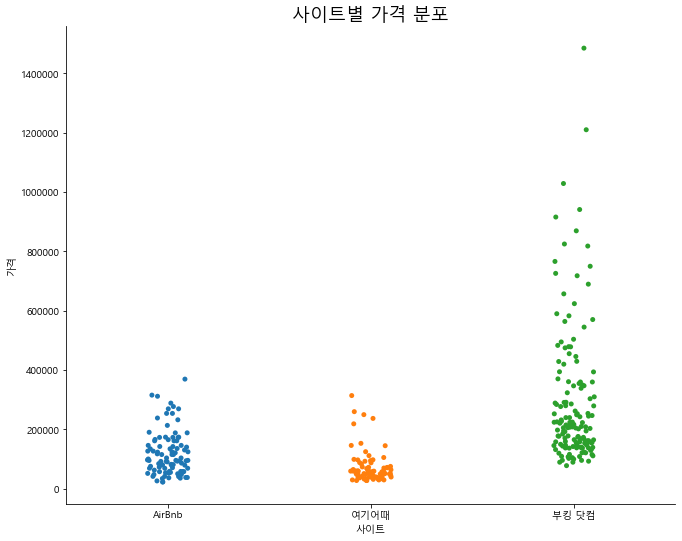

In [17]:
#사이트별 가격 분포


g = sns.catplot(x="사이트", y="가격", data=hotels_df)
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p : format(int(x), '')))
plt.title("사이트별 가격 분포", size=18)
g.fig.set_size_inches(10,8)

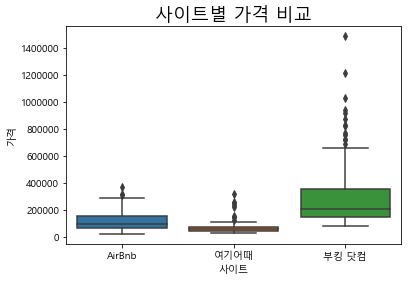

In [18]:
sns.boxplot(x="사이트",y="가격",data=hotels_df)
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p : format(int(x), '')))
plt.title("사이트별 가격 비교", size=18)
g.fig.set_size_inches(10,8)

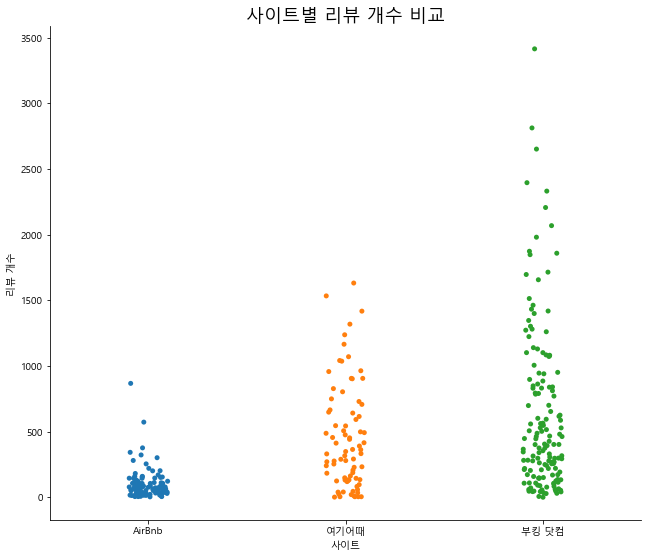

In [41]:
# 사이트별 리뷰 개수


g = sns.catplot(x="사이트", y="리뷰 개수", data=hotels_df)
plt.title("사이트별 리뷰 개수 비교", size=18)
g.fig.set_size_inches(10,8)

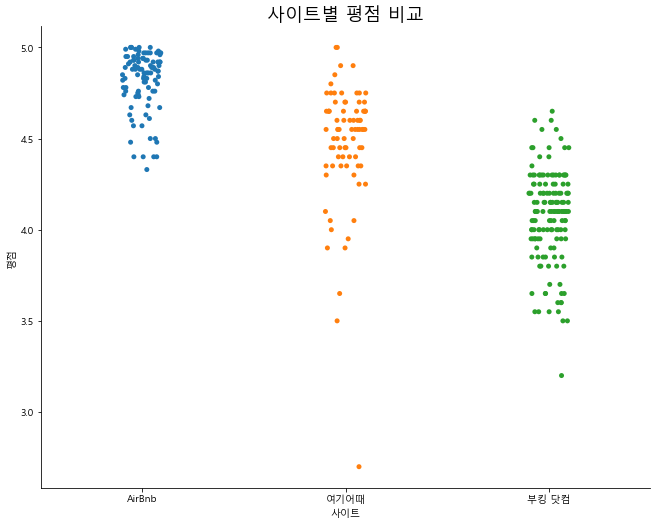

In [42]:
# 사이트별 평점 분포

g= sns.catplot(x="사이트", y="평점", data=hotels_df)
plt.title("사이트별 평점 비교", size=18)
plt.tight_layout()
g.fig.set_size_inches(10,8)
plt.show()
#plt.ylim(0, 5)

Text(0.5, 1.0, '버블 크기 : 리뷰 개수')

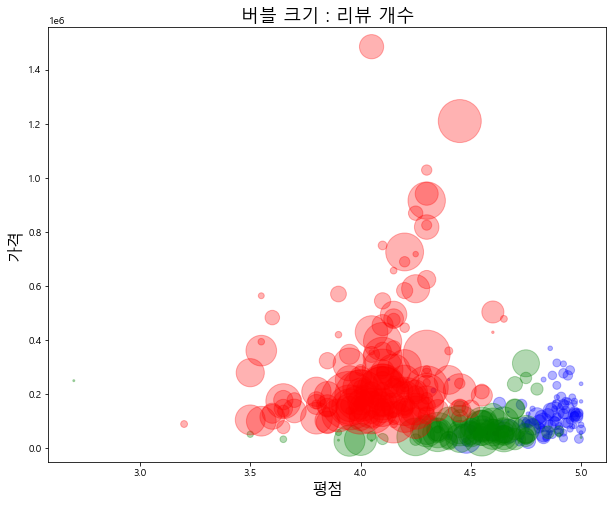

In [46]:
color = []

for i in range(len(hotels_df)):
    if hotels_df.iloc[i]['사이트'] == 'AirBnb':
        color.append('b')
#    elif hotels_df.iloc[i]['사이트'] == '호텔스닷컴':
#         color.append('y')
    elif hotels_df.iloc[i]['사이트'] == '여기어때':
        color.append('g')
    elif hotels_df.iloc[i]['사이트'] == '부킹 닷컴':
        color.append('r')

 
plt.figure(figsize=(10,8)) 
plt.scatter('평점', '가격',
             s='리뷰 개수',
             c=color,
             alpha=0.3, data=hotels_df)
plt.xlabel("평점", size=16)
plt.ylabel("가격", size=16)
plt.title("버블 크기 : 리뷰 개수", size=18)

Text(0.5, 1.0, '가격 vs 평점')

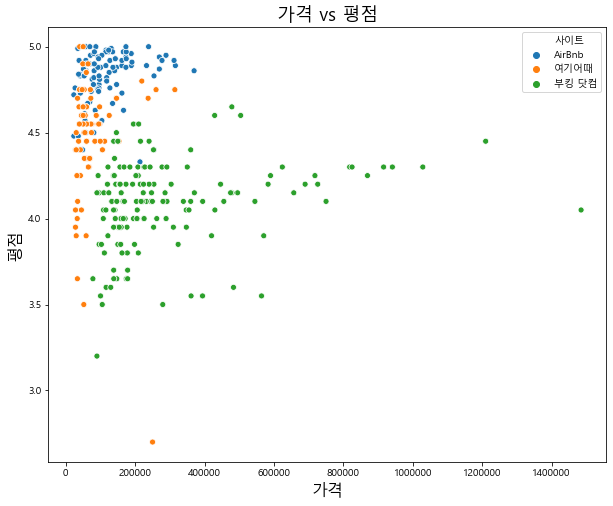

In [24]:
plt.figure(figsize=(10,8)) 
sns.scatterplot('가격', '평점',hue="사이트",
             data=hotels_df)
plt.gca().get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p : format(int(x), '')))
plt.xlabel("가격", size=16)
plt.ylabel("평점", size=16)
plt.title("가격 vs 평점", size=18)

In [51]:
print("여기어때 평균 평점 :",round(hotels_df[hotels_df["사이트"]=="여기어때"]["평점"].mean(),2))
print("에어비앤비 평균 평점 :",round(hotels_df[hotels_df["사이트"]=="AirBnb"]["평점"].mean(),2))
print("부킹닷컴 평균 평점 :",round(hotels_df[hotels_df["사이트"]=="부킹 닷컴"]["평점"].mean(),2))

여기어때 평균 평점 : 4.48
에어비앤비 평균 평점 : 4.82
부킹닷컴 평균 평점 : 4.08


In [73]:
hotels_df["가격"].median()

137700.0

In [89]:
hotels_df[hotels_df["가격"]>=137700]

,이름,평점,리뷰 개수,가격,사이트
0,제주안뜰_안채,4.88,34,146337,AirBnb
1,제주동쪽 정갈한 돌집과 가드닝창고_스테이뵤뵤,4.96,46,188544,AirBnb
2,스테이 일면식,4.94,91,269569,AirBnb
8,집전체에서 바다와 섬이 보이는 독채스테이 수리담,4.95,81,288824,AirBnb
15,[커플특가][노천탕무료]하루하나 더 노스텔지아 _ 프라이빗 노천탕이 있는 감성스테...,4.87,72,269569,AirBnb
...,...,...,...,...,...
341,시워터 스파 호텔 코자,4.10,242,147000,부킹 닷컴
342,J2 패밀리 호텔,4.00,374,142500,부킹 닷컴
343,취다선 리조트,4.65,47,478500,부킹 닷컴
344,굿데이펜션,4.55,220,210000,부킹 닷컴


## 워드클라우드를 이용한 리뷰 시각화


In [154]:
# 호텔스닷컴 호텔 난타

url = "https://kr.hotels.com/ho659575-tr/?q-check-in=2021-01-07&q-check-out=2021-01-10&q-rooms=1&q-room-0-adults=2&SYE=3&ZSX=0&MGT=3&YGF=14&WOD=4&WOE=7&applyEmbargo=false&reviewTab=brand-reviews&f-amid="

url_parsed=urllib.parse.urlparse(url)

url_qs=urllib.parse.parse_qs(url_parsed.query)
url_qs

{'q-check-in': ['2021-01-07'],
 'q-check-out': ['2021-01-10'],
 'q-rooms': ['1'],
 'q-room-0-adults': ['2'],
 'SYE': ['3'],
 'ZSX': ['0'],
 'MGT': ['3'],
 'YGF': ['14'],
 'WOD': ['4'],
 'WOE': ['7'],
 'applyEmbargo': ['false'],
 'reviewTab': ['brand-reviews']}

In [155]:
base_url="https://kr.hotels.com/ho659575-tr/"
params={'q-check-in': ['2021-01-07'],
 'q-check-out': ['2021-01-10'],
 'q-rooms': ['1'],
 'q-room-0-adults': ['2'],
 'SYE': ['3'],
 'ZSX': ['0'],
 'MGT': ['3'],
 'YGF': ['14'],
 'WOD': ['4'],
 'WOE': ['7'],
 'applyEmbargo': ['false'],
 'reviewTab': ['brand-reviews']}

In [156]:
resp=requests.get(base_url,params=params)
resp

<Response [200]>

In [166]:
soup=bs(resp.text)


In [165]:
review_tag=soup.find_all("blockquote",class_="expandable-content description")


In [164]:
review_list=[]

for i in review_tag:
    review_list.append(i.text)
    
review_list

['추천받아서 숙박하게되었는데요\n호텔도 너무 예쁘고 제주도 있으면서 가장 맘에든 숙소였어요 화장실도 가장 깔끔했고 침대가 엄청 푹신했어요 난방최고였어요 다음에 또 여행을 간다면 꼭 다시 가고싶어요^^',
 '두번째 방문인데 이번에도 만족스러웠어요. 우선 위치가 한적한데 있고 조용해서 좋아요! 폭설이 왔는데 직원분들이 친절하게 눈도 다 치워주시고 눈길운전도 알려주시고 감동이었습니다. 방도 깨끗하고 침대도 편하고 물도 2병 줍니다! 다만 조식은 별로라서 아쉬웠어요 제주도 갈때마다 방문할게요!!',
 '그냥 그랬어요 vip 액세스 혜택도 없고 산속에 있어서 싼맛에 묵긴 했지만 다시묵을 의향은 없어요',
 '룸 컨디션이 항상 좋아용:)',
 '',
 '제주 공항에서 좀 멀지만 조용하고 쾌적함\nCOVID 19 시대에.. 주변 음식점이 전혀 없어 불편하지만 호텔 룸서비스담당 chef staff 분들이 모두  친절하고 맛도 좋았음.',
 '대채로괜찬아요.다만욕실샤워물이밖으로나갈까염려됐어요',
 '숙박을하고 다음날 약을 먹으려고 하는데 생수가 떨어져서 약이 목에 걸려서 안내려가는 상황이였어요 그래수 생수 사러 편의점에 갔어요 오픈시간이라고 기재되어 있어서 그시간에 맞춰서 갔는데도 문을 안열었으며, 약이 목에걸려 조금 긴박한 상황이라 프론트에가서 물을 좀 얻고 싶다 아니면 사고싶다니 안된다며 딱잘라 거절하는 불성실한 직원의 태도에 아주 불쾌했으며 다시는 숙박을 하러오지 않겠다 마음을 먹었습니다. 결국 찾다 커피숍에가서 커피를 사고 물을 얻어서 먹었습니다. 이런 고객서비스는 살다가 처음 받아보네요',
 '신설인지 깔끔했네요. 겨울이라 해가 금방 져서 저녁에 룸서비스로 한식 주문해서 먹었는데 무난했습니다. 공간도 널직해서 답답한 느낌이 없었고 좋았어요',
 '방 깨끗하고 한라산 전망도 힐링포인트입니다. 재방문의사 있어요.',
 '가격 대비 좋고 한라산 등반 하기 전 날 아주 좋아요^^',
 '두번째 찾게된  숙소인데요 만족합니다.다만 타월이 낡아서 여기저기 구멍이 보여서 아쉬

In [251]:
# 리뷰 텍스트 파일 csv파일화
pd.DataFrame(review_list).to_csv("review_list.csv",encoding="utf-8-sig")

PermissionError: [Errno 13] Permission denied: 'review_list.csv'

In [227]:
# 텍스트 전처리를 위한 Okt 라이브러리

from konlpy.tag import Okt

In [239]:
okt=Okt()

pos_list=[]

for review in review_list:
    pos_list.append(okt.pos(review))

pos_list=sum(pos_list,[])


morphs_list=[]

for token in pos_list:
    if token[1] in ("Noun","Adjective"):
        morphs_list.append(okt.morphs(token[0]))
        
morphs_list=sum(morphs_list,[])
morphs_list
        

['추천',
 '숙박',
 '호텔',
 '예쁘고',
 '제주도',
 '있으면서',
 '가장',
 '맘',
 '숙소',
 '화장실',
 '가장',
 '깔끔했고',
 '침대',
 '푹신했어요',
 '난방',
 '최고',
 '다음',
 '또',
 '여행',
 '간다',
 '꼭',
 '다시',
 '두번째',
 '방문',
 '이번',
 '만족스러웠어요',
 '우선',
 '위치',
 '한적한데',
 '있고',
 '조용해서',
 '좋아요',
 '폭설',
 '직원',
 '친절하게',
 '눈',
 '눈길',
 '운전',
 '감동',
 '방도',
 '깨끗하고',
 '침대',
 '편하고',
 '물',
 '병',
 '다만',
 '조식',
 '별로',
 '아쉬웠어요',
 '제주도',
 '때',
 '방문',
 '그냥',
 '그랬어요',
 '액세스',
 '혜택',
 '없고',
 '산속',
 '있어서',
 '맛',
 '다시',
 '묵',
 '의향',
 '없어요',
 '룸',
 '컨디션',
 '항상',
 '좋아용',
 '제주',
 '공항',
 '좀',
 '멀지만',
 '조용하고',
 '쾌적함',
 '시대',
 '주변',
 '음식점',
 '전혀',
 '없어',
 '불편하지만',
 '호텔',
 '룸서비스',
 '담당',
 '분',
 '모두',
 '친절하고',
 '맛',
 '좋았음',
 '채',
 '괜',
 '다만',
 '욕실',
 '샤워',
 '물이',
 '밖',
 '염려',
 '숙박',
 '다음',
 '날',
 '약',
 '생수',
 '약',
 '목',
 '상황',
 '그래수',
 '생수',
 '편의점',
 '오픈',
 '시간',
 '기재',
 '있어서',
 '시간',
 '문',
 '약',
 '목',
 '조금',
 '긴박한',
 '상황',
 '프론트',
 '에가',
 '물',
 '좀',
 '아니면',
 '안된다며',
 '거절',
 '불성실한',
 '직원',
 '태도',
 '아주',
 '불쾌했으며',
 '숙박',
 '마음',
 '커피숍',
 '커피',
 '사고',
 '물',
 '이런',
 '고

In [241]:
from collections import Counter

count = Counter(morphs_list)
words = dict(count.most_common())
words


{'호텔': 15,
 '한라산': 10,
 '깨끗하고': 9,
 '냄새': 9,
 '다만': 7,
 '좋았어요': 7,
 '수건': 7,
 '숙박': 6,
 '위치': 6,
 '좋아요': 6,
 '조식': 6,
 '샤워': 6,
 '곳': 6,
 '주차장': 6,
 '숙소': 5,
 '다음': 5,
 '있어서': 5,
 '입니다': 5,
 '등반': 5,
 '좋았습니다': 5,
 '매우': 5,
 '객실': 5,
 '제주도': 4,
 '방문': 4,
 '직원': 4,
 '때': 4,
 '고객': 4,
 '저녁': 4,
 '가격': 4,
 '대비': 4,
 '타월': 4,
 '사용': 4,
 '가성': 4,
 '청결': 4,
 '청소': 4,
 '후': 4,
 '추천': 3,
 '침대': 3,
 '또': 3,
 '여행': 3,
 '꼭': 3,
 '다시': 3,
 '물': 3,
 '산속': 3,
 '공항': 3,
 '좀': 3,
 '주변': 3,
 '룸서비스': 3,
 '날': 3,
 '약': 3,
 '아주': 3,
 '마음': 3,
 '서비스': 3,
 '방': 3,
 '난타': 3,
 '예약': 3,
 '있어': 3,
 '비': 3,
 '수': 3,
 '실내': 3,
 '점': 3,
 '시설': 3,
 '치약': 3,
 '칫솔': 3,
 '소리': 3,
 '아침': 3,
 '엄마': 3,
 '정말': 3,
 '것': 3,
 '거': 3,
 '생각': 3,
 '가장': 2,
 '두번째': 2,
 '이번': 2,
 '방도': 2,
 '별로': 2,
 '아쉬웠어요': 2,
 '없고': 2,
 '맛': 2,
 '묵': 2,
 '없어요': 2,
 '룸': 2,
 '조용하고': 2,
 '전혀': 2,
 '없어': 2,
 '분': 2,
 '모두': 2,
 '욕실': 2,
 '생수': 2,
 '목': 2,
 '상황': 2,
 '시간': 2,
 '문': 2,
 '조금': 2,
 '프론트': 2,
 '이런': 2,
 '처음': 2,
 '해': 2,
 '무난': 2,
 '답답한'

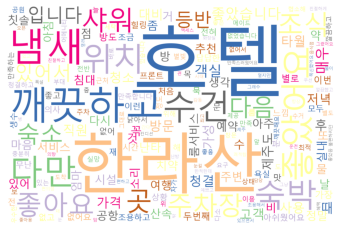

In [243]:
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r", width=1500, height=1000).generate_from_frequencies(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

